In [ ]:
# Get dataset from https://www.kaggle.com/competitions/digit-recognizer/overview
#importing necessary libraries
import numpy as np               #used for numerical operations
import matplotlib.pyplot as plt  #used for plotting graphs   
import pandas as pd             #used for data manipulation and analysis

In [124]:
df = pd.read_csv(r"/Applications/my_work/Digit_Recoqnizer/digit-recognizer/train.csv")  #reading the csv file 

In [131]:
#convert to array for algebra
df = np.array(df)
#shape of the array, m gives the number of digits (rows) and n gives the number of pixels of each images (columns)
m, n = df.shape
print(m, n)

#randomly shuffle the dataset, why? to make sure no bias in the data
np.random.shuffle(df)

#slices out the part of the dataset that will be used for validation and takes a transpose of the array
data_dev = df[1000:m,:].T  # Fixed: use proper range for dev set

# These lines extract the labels (Y_dev) and the features (X_dev) from the development set:
# Y_dev is the first row after transpose (labels)
# X_dev contains all other rows (features)
Y_dev = data_dev[0]  # Fixed: get labels from transposed data
X_dev = data_dev[1:n]  # Fixed: get features from transposed data
X_dev = X_dev / 255.0  # normalize pixel values

#training data
data_train = df[0:,:].T  # Fixed: proper slicing
Y_train = data_train[0]  # Fixed: get labels from transposed data
X_train = data_train[1:n]  # Fixed: get features from transposed data
X_train = X_train / 255.0  # normalize pixel values

print(f"Training set shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Dev set shape: X_dev: {X_dev.shape}, Y_dev: {Y_dev.shape}")

# In summary, this code preprocesses a dataset for machine learning tasks involving image data. 
# It splits the dataset into training and validation sets, extracts features and labels, shuffles the data,
# and normalizes the pixel values of the images.

42000 785
Training set shape: X_train: (784, 42000), Y_train: (42000,)
Dev set shape: X_dev: (784, 41000), Y_dev: (41000,)


In [126]:
#Functions to train the NN 

#initialization function to get random weights and biases
def init_params():
    w1 = np.random.rand(128, 784) - 0.5   # first hidden layer (128 neurons for ex.)
    b1 = np.random.rand(128, 1) - 0.5
    w2 = np.random.rand(64, 128) - 0.5    # second hidden layer (64 neurons)
    b2 = np.random.rand(64, 1) - 0.5
    w3 = np.random.rand(10, 64) - 0.5     # output layer (10 classes)
    b3 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2, w3, b3

def ReLU(Z):
    return np.maximum(0,Z)

def ReLU_deriv(Z):
    return Z > 0

#softmax function to convert the output into a probability distribution
def softmax(Z):
    exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Fixed: proper axis handling
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)  # Fixed: proper axis handling

# This function converts class labels into a special format called "one-hot encoding." 
# It creates an array where each row represents a different class, and each column represents a sample. 
# If a sample belongs to a class, the corresponding value in that class's row is set to 1; otherwise, it's set to 0.
def one_hot(Y):
    num_classes = np.max(Y) + 1
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1 #Its like saying put 1s in these specific spots of the matrix
    return one_hot_Y

# This function performs forward propagation in a neural network, computing the activations of hidden layers (A1) 
# and output layer (A2) given the input features (X) and learned parameters (weights W1 and W2, biases b1 and b2), 
# utilizing Rectified Linear Unit (ReLU) activation for the hidden layer and Softmax activation for the output layer.
#we need z1 and z2 for gradient descent
def forward_prop(w1, b1, w2, b2, w3, b3, X):
    z1 = w1.dot(X) + b1
    a1 = ReLU(z1)

    z2 = w2.dot(a1) + b2
    a2 = ReLU(z2)

    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)

    return z1, a1, z2, a2, z3, a3

# This function computes the gradients of the loss function with respect to the parameters (weights and biases) using backward propagation.
# It calculates the gradients for both hidden and output layers (dW1, db1, dW2, db2) based on the given input (X), target labels (Y),
# activations of the hidden layer (A1) and output layer (A2), and intermediate values (Z1, Z2) computed during forward propagation.
# we are performing this on the entire batch of training data
def back_prop(z1, a1, z2, a2, z3, a3, w2, w3, X, Y):
    m = Y.size #number of training examples
    one_hot_Y = one_hot(Y)
    dz3 = a3 - one_hot_Y
    dw3 = 1/m * dz3.dot(a2.T) #T for array multiplication
    db3 = 1/m * np.sum(dz3, axis=1, keepdims=True)# proper bias gradient calculation, we are collecting errors for each neuron and taking and average

    dz2 = w3.T.dot(dz3) * ReLU_deriv(z2) # relu deriv returns 1 if z1 is positive, 0 otherwise
    dw2 = 1/m * dz2.dot(a1.T)
    db2 = 1/m * np.sum(dz2, axis=1, keepdims=True)
    
    dz1 = w2.T.dot(dz2) * ReLU_deriv(z1)
    dw1 = 1/m * dz1.dot(X.T)
    db1 = 1/m * np.sum(dz1, axis=1, keepdims=True)

    return dw1, db1, dw2, db2, dw3, db3

# This function updates the parameters (weights and biases) of the neural network using gradient descent to minimize the loss function, for learning 
def update_params(w1,b1,w2,b2,w3,b3,dw1,db1,dw2,db2,dw3,db3,alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    w3 = w3 - alpha * dw3
    b3 = b3 - alpha * db3
    return w1, b1, w2, b2, w3, b3

In [127]:
def get_predictions(a3):
    return np.argmax(a3,0) #returns the index of the highest value in each column

# This function calculates the accuracy of the predictions by comparing them with the true labels and dividing the number 
# of correct predictions by the total number of samples.
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# This function implements gradient descent to train the neural network. It iteratively updates the parameters (weights and biases)
# based on the gradients of the loss function with respect to these parameters. It prints the iteration number and accuracy every 10 iterations.
# Finally, it returns the updated parameters.
def gradient_descent(X, Y, alpha, iterations):
    w1, b1, w2, b2, w3, b3 = init_params()
    for i in range (iterations):
        z1,a1,z2,a2,z3,a3 = forward_prop(w1,b1,w2,b2,w3,b3,X)
        dw1, db1, dw2, db2, dw3, db3 = back_prop(z1, a1, z2, a2, z3, a3, w2, w3, X, Y)
        w1, b1, w2, b2, w3, b3 = update_params(w1,b1,w2,b2,w3,b3,dw1,db1,dw2,db2,dw3,db3,alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(a3)
            print(get_accuracy(predictions, Y))
    return w1, b1, w2, b2, w3, b3

In [132]:
w1, b1, w2, b2,w3, b3 = gradient_descent(X_train, Y_train, 0.10, 1000)

Iteration:  0
0.13130952380952382
Iteration:  10
0.49454761904761907
Iteration:  20
0.634
Iteration:  30
0.6987142857142857
Iteration:  40
0.7376190476190476
Iteration:  50
0.763095238095238
Iteration:  60
0.7808333333333334
Iteration:  70
0.7970238095238096
Iteration:  80
0.8097380952380953
Iteration:  90
0.819047619047619
Iteration:  100
0.8275238095238096
Iteration:  110
0.835
Iteration:  120
0.8415
Iteration:  130
0.8469761904761904
Iteration:  140
0.8515238095238096
Iteration:  150
0.8562380952380952
Iteration:  160
0.8603571428571428
Iteration:  170
0.8647857142857143
Iteration:  180
0.8680476190476191
Iteration:  190
0.8707857142857143
Iteration:  200
0.8735238095238095
Iteration:  210
0.8760476190476191
Iteration:  220
0.8782857142857143
Iteration:  230
0.8805238095238095
Iteration:  240
0.8825952380952381
Iteration:  250
0.8845952380952381
Iteration:  260
0.8864285714285715
Iteration:  270
0.8884047619047619
Iteration:  280
0.8900476190476191
Iteration:  290
0.8922857142857142

In [133]:
# This function generates predictions using the input data and the trained parameters.
def make_predictions(X, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, a3 = forward_prop(w1, b1, w2, b2, w3, b3, X)
    predictions = get_predictions(a3)
    return predictions

# This function tests a single prediction using the trained parameters on a specific index of the dataset. 
# It prints the predicted label and the actual label.
def test_prediction(index, w1, b1, w2, b2, w3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w1, b1, w2, b2, w3, b3)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label) 
    # This code reshapes the image data to its original 28x28 dimensions and then visualizes it 
    # using matplotlib's imshow function, displaying the grayscale image.
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [8]
Label:  8


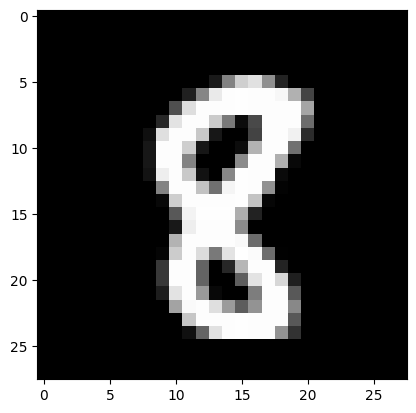

In [141]:
# This function tests the prediction for a specific index in the training dataset using the trained parameters W1, b1, W2, and b2. 
# It prints the prediction, actual label, and displays the corresponding image.
    
test_prediction(90, w1, b1, w2, b2, w3, b3)


Prediction:  [3]
Label:  3


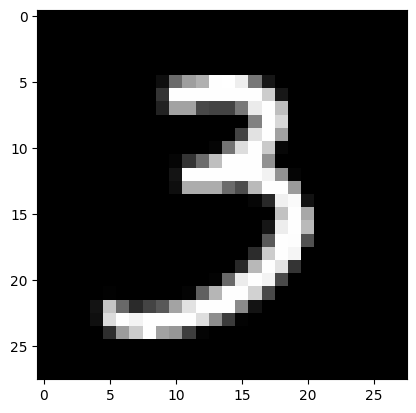

In [142]:
test_prediction(44, w1, b1, w2, b2, w3, b3)